# **Práctica   6  Inferencia de parámetros en modelos ARIMA**

**Carrera:** Licenciatura en Ciencia de Datos

**Grupo:**  6AV1

**Materia:** Análisis de Series de Tiempo

**Docente:** Daniel Jiménez Alcantar

**Alumno:**  
* Aguilar Ramirez Carlos Francisco
* Arista Romero Juan Ismael
* Jiménez Flores Luis Arturo
* Vazquez Martin Marlene Gabriela


Fecha de última modificación: 26/04/2025

## Análisis de Series de Tiempo - Temperaturas Mínimas Diarias

### **IMPORTACIÓN DE LIBRERÍAS**

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.signal import find_peaks
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore") # Para ocultar advertencias comunes

#### **Funciones de Carga y Preparación de Datos**

In [23]:
def cargar_y_preparar_datos(file_path, date_col_original, value_col_original, date_format, value_col_nuevo='valor', date_col_nuevo='fecha'):
    """
    Carga datos desde un CSV, realiza limpieza inicial, parsea fechas,
    maneja NaNs en la columna de valor y renombra columnas.

        file_path (str): Ruta al archivo CSV.
        date_col_original (str): Nombre original de la columna de fecha.
        value_col_original (str): Nombre original de la columna de valor.
        date_format (str): Formato de la fecha en el CSV (ej. '%m/%d/%Y').
        value_col_nuevo (str): Nuevo nombre para la columna de valor.
        date_col_nuevo (str): Nuevo nombre para la columna de fecha.

    """
    print(f"\n--- 2. Cargando y Preparando Datos desde: {file_path} ---")
    try:
        df = pd.read_csv(file_path)
        print("Datos cargados exitosamente.")
    except FileNotFoundError:
        print(f"Error: No se encontró el archivo en la ruta especificada: {file_path}")
        return None

    # Renombrar columnas originales si existen
    col_rename_map = {}
    if date_col_original in df.columns:
        col_rename_map[date_col_original] = date_col_nuevo
    else:
         print(f"Advertencia: Columna de fecha original '{date_col_original}' no encontrada.")
         return None # O manejar el error de otra forma
    if value_col_original in df.columns:
        col_rename_map[value_col_original] = value_col_nuevo
    else:
         print(f"Advertencia: Columna de valor original '{value_col_original}' no encontrada.")
         return None # O manejar el error

    df.rename(columns=col_rename_map, inplace=True)

    # Convertir columna de valor a numérico, manejar errores
    df[value_col_nuevo] = pd.to_numeric(df[value_col_nuevo], errors='coerce')

    # Convertir columna de fecha a datetime
    try:
        df[date_col_nuevo] = pd.to_datetime(df[date_col_nuevo], format=date_format)
    except Exception as e:
        print(f"Error al parsear fechas con formato '{date_format}': {e}")
        return None

    # Ordenar por fecha
    df.sort_values(date_col_nuevo, inplace=True)

    # Verificar y manejar NaNs en la columna de valor
    if df[value_col_nuevo].isnull().any():
        print(f"Se encontraron {df[value_col_nuevo].isnull().sum()} NaNs en '{value_col_nuevo}'. Rellenando con interpolación lineal...")
        df[value_col_nuevo].interpolate(method='linear', inplace=True)
        # Verificar si aún quedan NaNs (podrían estar al principio/final)
        if df[value_col_nuevo].isnull().any():
             print("NaNs restantes después de interpolar, rellenando con forward/backward fill...")
             df[value_col_nuevo].fillna(method='ffill', inplace=True)
             df[value_col_nuevo].fillna(method='bfill', inplace=True)
    else:
        print(f"No se encontraron NaNs en '{value_col_nuevo}'.")

    print("\nInspección inicial del DataFrame procesado:")
    print("Primeras 5 filas:")
    print(df.head().to_markdown(index=False, numalign="left", stralign="left"))
    print("\nInformación general:")
    df.info()
    print("\nEstadísticas descriptivas:")
    print(df[[value_col_nuevo]].describe().to_markdown(numalign="left", stralign="left"))

    return df

def preparar_serie_tiempo(df, date_col='fecha', value_col='valor', series_name="Serie de Tiempo"):
    """
    Prepara la serie de tiempo final estableciendo el índice de fecha.

    Args:
        df (pandas.DataFrame): DataFrame preprocesado.
        date_col (str): Nombre de la columna de fecha.
        value_col (str): Nombre de la columna de valor.
        series_name (str): Nombre para la serie resultante.

    Returns:
        pandas.Series: Serie de tiempo lista para análisis.
    """
    print(f"\n--- 3. Preparando la Serie de Tiempo Final ('{value_col}') ---")
    if date_col not in df.columns or value_col not in df.columns:
         print(f"Error: Las columnas '{date_col}' o '{value_col}' no existen en el DataFrame.")
         return None

    ts_df = df[[date_col, value_col]].copy()
    ts_df.set_index(date_col, inplace=True)
    serie = ts_df[value_col].dropna()
    serie.name = series_name

    print(f"\nSerie '{serie.name}' preparada. Longitud: {len(serie)} puntos.")
    if not serie.empty:
        print(f"Fechas desde {serie.index.min().strftime('%Y-%m-%d')} hasta {serie.index.max().strftime('%Y-%m-%d')}")
        print("Últimas 5 observaciones:")
        print(serie.tail().to_markdown(numalign="left", stralign="left"))
    else:
        print("La serie está vacía después del preprocesamiento.")

    return serie

#### **Funciones de Análisis Exploratorio (EDA)**

In [24]:
def visualizar_serie_temporal(serie, titulo="Serie de Tiempo", ylabel="Valor"):
    """Grafica la serie de tiempo."""
    print(f"\n4.1 Visualizando '{serie.name}'...")
    plt.figure(figsize=(14, 7))
    plt.plot(serie.index, serie, linewidth=1)
    plt.title(titulo)
    plt.xlabel('Fecha')
    plt.ylabel(ylabel)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def calcular_estadisticas_descriptivas(serie):
    """Calcula y muestra estadísticas descriptivas detalladas."""
    print(f"\n4.2 Estadísticas Descriptivas de '{serie.name}'...")
    if serie.empty:
        print("La serie está vacía, no se pueden calcular estadísticas.")
        return None

    stats = {
        "Promedio (Media)": serie.mean(), "Mediana": serie.median(),
        "Moda": serie.mode().iloc[0] if not serie.mode().empty else 'N/A',
        "Desviación Estándar": serie.std(), "Varianza": serie.var(),
        "Mínimo": serie.min(), "Máximo": serie.max(),
        "Percentil 25 (Q1)": serie.quantile(0.25),
        "Percentil 75 (Q3)": serie.quantile(0.75),
        "Rango Intercuartílico (IQR)": serie.quantile(0.75) - serie.quantile(0.25)
    }
    print("Estadísticas detalladas:")
    for key, value in stats.items():
        try:
            print(f"  {key}: {float(value):.4f}")
        except (TypeError, ValueError):
            print(f"  {key}: {value}") # Imprime no numéricos tal cual
    return stats

def analizar_granularidad_max_min(serie):
    """Analiza granularidad diaria y muestra máximos/mínimos globales."""
    print(f"\n4.3 Análisis de Granularidad, Máximos y Mínimos para '{serie.name}'...")
    if not isinstance(serie.index, pd.DatetimeIndex) or serie.empty:
        print("El índice no es DatetimeIndex o la serie está vacía.")
        return

    # Granularidad
    date_diff = serie.index.to_series().diff().dt.days
    date_diff_counts = date_diff.value_counts().head()
    print("Granularidad (diferencias más frecuentes en días):")
    print(date_diff_counts.to_markdown(numalign="left", stralign="left"))
    if not date_diff_counts.empty and date_diff_counts.index[0] == 1 and date_diff_counts.iloc[0] > len(serie) * 0.9:
         print("Comentario: La serie tiene una granularidad predominantemente diaria.")
    else:
         print("Comentario: La granularidad no es estrictamente diaria o hay saltos.")

    # Máximos y Mínimos
    max_val = serie.max()
    min_val = serie.min()
    max_val_date = serie.idxmax()
    min_val_date = serie.idxmin()
    print(f"\nMáximo absoluto: {max_val:.4f} el {max_val_date.strftime('%Y-%m-%d')}")
    print(f"Mínimo absoluto: {min_val:.4f} el {min_val_date.strftime('%Y-%m-%d')}")

def visualizar_tendencia_media_movil(serie, window, titulo="Análisis de Tendencia", ylabel="Valor"):
    """Grafica la serie con su media móvil."""
    print(f"\n4.4 Visualizando Tendencia (Media Móvil {window} días) para '{serie.name}'...")
    if serie.empty: return
    serie_moving_avg = serie.rolling(window=window, center=True, min_periods=int(window/2)).mean()
    plt.figure(figsize=(14, 7))
    plt.plot(serie.index, serie, alpha=0.5, label=f'{serie.name} (Original)', linewidth=0.8)
    plt.plot(serie_moving_avg.index, serie_moving_avg, color='red', linewidth=2, label=f'Promedio Móvil {window} días')
    plt.title(titulo)
    plt.xlabel('Fecha')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def descomponer_serie_estacional(serie, period, model='additive', titulo="Descomposición Estacional"):
    """Realiza y grafica la descomposición estacional."""
    print(f"\n4.5 Descomponiendo '{serie.name}' (Periodo={period}, Modelo={model})...")
    if serie.empty: return
    try:
        decomposition = seasonal_decompose(serie, model=model, period=period)
        fig = decomposition.plot()
        fig.set_size_inches(14, 10)
        plt.suptitle(titulo, y=1.02, fontsize=16)
        axes = fig.get_axes()
        axes[0].set_ylabel('Observado')
        axes[1].set_ylabel('Tendencia')
        axes[2].set_ylabel('Estacional')
        axes[3].set_ylabel('Residual')
        for ax in axes: ax.grid(True, linestyle='--', alpha=0.5)
        plt.tight_layout(rect=[0, 0.03, 1, 0.98])
        plt.show()
        return decomposition
    except Exception as e:
        print(f"Error durante la descomposición: {e}")
        return None

def identificar_picos_valles(serie, distance, prominence=1, titulo="Picos y Valles Locales", ylabel="Valor"):
    """Encuentra y grafica picos y valles locales."""
    print(f"\n4.6 Identificando Picos y Valles en '{serie.name}' (distance={distance})...")
    if serie.empty: return None, None
    peaks_indices, _ = find_peaks(serie, distance=distance, prominence=prominence)
    peaks = serie.iloc[peaks_indices]
    valleys_indices, _ = find_peaks(-serie, distance=distance, prominence=prominence)
    valleys = serie.iloc[valleys_indices]

    plt.figure(figsize=(14, 7))
    plt.plot(serie.index, serie, label=f'{serie.name}', linewidth=0.9)
    plt.scatter(peaks.index, peaks.values, color='red', label='Picos Locales', marker='^', s=60, zorder=5)
    plt.scatter(valleys.index, valleys.values, color='blue', label='Valles Locales', marker='v', s=60, zorder=5)
    plt.title(titulo)
    plt.xlabel('Fecha')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    print(f"Número de picos locales detectados: {len(peaks)}")
    print(f"Número de valles locales detectados: {len(valleys)}")
    return peaks, valleys

def calcular_cambio_promedio_anual(serie, titulo="Cambio Promedio Anual", ylabel="Cambio (%)"):
    """Calcula y grafica el cambio porcentual promedio anual."""
    print(f"\n4.7 Calculando Cambio Promedio Anual para '{serie.name}'...")
    if not isinstance(serie.index, pd.DatetimeIndex) or serie.empty:
        print("El índice no es DatetimeIndex o la serie está vacía.")
        return None

    annual_means = serie.groupby(serie.index.year).mean()
    annual_change = annual_means.pct_change() * 100 # Cambio porcentual
    annual_change_df = annual_change.dropna().reset_index()
    if annual_change_df.empty:
        print("No hay suficientes años para calcular el cambio anual.")
        return None

    annual_change_df.columns = ['Año', 'Cambio Promedio Anual (%)']

    print("Primeras filas del cambio promedio anual:")
    print(annual_change_df.head().to_markdown(numalign="left", stralign="left"))

    plt.figure(figsize=(14, 6))
    sns.barplot(data=annual_change_df, x='Año', y='Cambio Promedio Anual (%)', palette='coolwarm')
    plt.xticks(rotation=90, fontsize=8)
    plt.title(titulo)
    plt.xlabel('Año')
    plt.ylabel(ylabel)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    ax = plt.gca()
    n_years = len(annual_change_df['Año'])
    tick_spacing = max(1, n_years // 20)
    ax.set_xticks(ax.get_xticks()[::tick_spacing])
    ax.tick_params(axis='x', labelsize=8)
    plt.tight_layout()
    plt.show()
    return annual_change_df


#### **Funciones de Modelado ARIMA**

In [25]:
def realizar_prueba_adf(serie):
    """Realiza la prueba ADF y devuelve si es estacionaria y el p-value."""
    print(f'\n5.1.1 Resultados de la Prueba Dickey-Fuller Aumentada para {serie.name}:')
    if serie.empty:
        print("La serie está vacía.")
        return False, None
    try:
        dftest = adfuller(serie.dropna(), autolag='AIC')
        p_value = dftest[1]
        dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        for key,value in dftest[4].items():
            dfoutput['Critical Value (%s)'%key] = value
        print(dfoutput.to_markdown(numalign="left", stralign="left"))
        estacionaria = p_value <= 0.05
        conclusion = "estacionaria" if estacionaria else "NO estacionaria"
        print(f"  Conclusión: La serie es probablemente {conclusion} (p-value={p_value:.4f}).")
        return estacionaria, p_value
    except Exception as e:
        print(f"Error durante la prueba ADF: {e}")
        return False, None


def identificar_orden_diferenciacion(serie, max_d=2):
    """Determina el orden de diferenciación 'd' necesario."""
    estacionaria, _ = realizar_prueba_adf(serie)
    d = 0
    serie_estacionaria = serie.copy()
    if estacionaria:
        print(f"\nLa serie original '{serie.name}' ES estacionaria (d=0).")
        return d, serie_estacionaria

    print(f"\nLa serie original '{serie.name}' NO es estacionaria. Aplicando diferencias...")
    for i in range(1, max_d + 1):
        serie_diff = serie_estacionaria.diff().dropna()
        serie_diff.name = f"{serie.name} (d={i})"
        estacionaria_diff, _ = realizar_prueba_adf(serie_diff)
        if estacionaria_diff:
            print(f"\nLa serie se vuelve estacionaria con d={i}.")
            return i, serie_diff
        serie_estacionaria = serie_diff # Prepara para la siguiente iteración

    print(f"\nAdvertencia: La serie no se volvió estacionaria después de {max_d} diferencias.")
    print("Se usará d={max_d}. Considera transformaciones adicionales o modelos estacionales.")
    return max_d, serie_estacionaria


def visualizar_acf_pacf(serie, lags, titulo_extra=""):
    """Grafica ACF y PACF de la serie."""
    print(f"\n5.1.2 Analizando ACF y PACF de '{serie.name}' {titulo_extra}...")
    if serie.empty: return
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    plot_acf(serie, ax=axes[0], lags=lags, title=f'ACF de {serie.name}')
    axes[0].grid(True, linestyle='--', alpha=0.5)
    plot_pacf(serie, ax=axes[1], lags=lags, title=f'PACF de {serie.name}', method='ywm')
    axes[1].grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


def dividir_datos_entrenamiento_prueba(serie, train_ratio=0.8):
    """Divide la serie en conjuntos de entrenamiento y prueba."""
    if serie.empty: return None, None
    split_index = int(len(serie) * train_ratio)
    train_data = serie[:split_index]
    test_data = serie[split_index:]
    print(f"\n--- División de Datos ---")
    print(f"Tamaño Total: {len(serie)}, Ratio Entrenamiento: {train_ratio*100}%")
    print(f"Tamaño Entrenamiento: {len(train_data)} ({train_data.index.min().strftime('%Y-%m-%d')} a {train_data.index.max().strftime('%Y-%m-%d')})")
    print(f"Tamaño Prueba:      {len(test_data)} ({test_data.index.min().strftime('%Y-%m-%d')} a {test_data.index.max().strftime('%Y-%m-%d')})")
    return train_data, test_data


def ajustar_modelo_arima(train_data, order):
    """Ajusta un modelo ARIMA y devuelve el resultado."""
    print(f"\n--- 5.2 Ajustando modelo ARIMA{order} ---")
    if train_data.empty:
        print("No hay datos de entrenamiento para ajustar el modelo.")
        return None
    try:
        modelo = ARIMA(train_data, order=order)
        modelo_ajustado = modelo.fit()
        print("\nResumen del Modelo Ajustado:")
        print(modelo_ajustado.summary())
        return modelo_ajustado
    except MemoryError:
         print(f"\nERROR de Memoria al ajustar ARIMA{order}. Intenta con menos datos o un modelo más simple.")
         return None
    except Exception as e:
        print(f"\nERROR al ajustar ARIMA{order}: {e}")
        return None


def diagnosticar_modelo(modelo_ajustado, lags):
    """Realiza diagnóstico de residuos (gráficos y Ljung-Box)."""
    print(f"\n--- 5.3 Diagnóstico del Modelo ---")
    if modelo_ajustado is None:
        print("El modelo no está ajustado, no se puede diagnosticar.")
        return False # Indica fallo en diagnóstico

    residuos = modelo_ajustado.resid

    # 5.3.1 Gráfico Residuos vs Tiempo
    print("\n5.3.1 Gráfico de Residuos vs Tiempo...")
    plt.figure(figsize=(14, 5))
    plt.plot(residuos.index, residuos, linewidth=1)
    plt.title('Residuos del Modelo ARIMA vs Tiempo')
    plt.axhline(0, linestyle='--', color='gray', alpha=0.7)
    plt.grid(True, linestyle='--', alpha=0.5); plt.tight_layout(); plt.show()

    # 5.3.2 ACF y QQ-plot Residuos
    print("\n5.3.2 ACF y QQ-Plot de Residuos...")
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    plot_acf(residuos, lags=lags, ax=axes[0], title='ACF de Residuos')
    axes[0].grid(True, linestyle='--', alpha=0.5)
    sm.qqplot(residuos, line='s', ax=axes[1])
    axes[1].set_title('QQ-Plot de Residuos'); axes[1].grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout(); plt.show()

    # 5.3.3 Ljung-Box Test
    print("\n5.3.3 Prueba de Ljung-Box para autocorrelación de residuos...")
    ljung_box_lags = min(lags, len(residuos)//5, 40) # Lags razonables
    try:
        ljung_box_result = sm.stats.acorr_ljungbox(residuos, lags=ljung_box_lags, return_df=True)
        print(ljung_box_result.to_markdown(numalign="left", stralign="left"))
        # Interpretar
        problemas_autocorrelacion = (ljung_box_result['lb_pvalue'] < 0.05).any()
        if problemas_autocorrelacion:
            print("\nResultado Ljung-Box: ¡Advertencia! Autocorrelación significativa en residuos (p<0.05).")
            print("El modelo NO captura toda la estructura. Considera SARIMA o revisar órdenes.")
            return False # Diagnóstico no OK
        else:
            print("\nResultado Ljung-Box: Residuos parecen independientes (ruido blanco).")
            return True # Diagnóstico OK
    except Exception as e_lb:
        print(f"Error al calcular la prueba de Ljung-Box: {e_lb}")
        return False


def realizar_prediccion(modelo_ajustado, steps, test_index):
    """Genera predicciones y intervalos de confianza."""
    print(f"\n--- 5.4 Realizando Predicción ({steps} pasos) ---")
    if modelo_ajustado is None: return None, None
    try:
        forecast_results = modelo_ajustado.get_forecast(steps=steps)
        pred_mean = forecast_results.predicted_mean
        pred_ci = forecast_results.conf_int(alpha=0.05) # 95% CI
        # Asignar índice correcto
        pred_mean.index = test_index
        pred_ci.index = test_index
        print("Predicciones generadas exitosamente.")
        return pred_mean, pred_ci
    except Exception as e_pred:
        print(f"Error durante la generación de predicciones: {e_pred}")
        return None, None


def visualizar_prediccion(train_data, test_data, pred_mean, pred_ci, order, ylabel="Valor", zoom_ultimos_anios=2):
    """Visualiza datos de entrenamiento, prueba y predicciones."""
    print("\n5.4.1 Visualización de Predicciones vs Datos Reales...")
    if pred_mean is None or test_data is None:
        print("Faltan datos para la visualización.")
        return

    plt.figure(figsize=(14, 7))
    # Mostrar solo los últimos años de entrenamiento para claridad
    ultimos_entreno = train_data[-(365 * zoom_ultimos_anios):] if not train_data.empty else None
    if ultimos_entreno is not None:
         plt.plot(ultimos_entreno.index, ultimos_entreno, label=f'Entrenamiento (últimos {zoom_ultimos_anios} años)', alpha=0.7)

    plt.plot(test_data.index, test_data, label='Datos Reales (Prueba)', color='orange', linewidth=2)
    plt.plot(pred_mean.index, pred_mean, label=f'Predicciones ARIMA{order}', color='green', linestyle='--')
    if pred_ci is not None:
        plt.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1],
                         color='k', alpha=0.15, label='Intervalo Confianza 95%')

    plt.title(f'Predicciones ARIMA{order} vs Datos Reales')
    plt.xlabel('Fecha'); plt.ylabel(ylabel)
    plt.legend(loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    # Zoom
    try: # Añadido try-except por si test_data está vacío
        plt.xlim([test_data.index.min() - pd.Timedelta(days=90), test_data.index.max() + pd.Timedelta(days=5)])
        y_min = min(test_data.min() if not test_data.empty else 0, pred_mean.min() if not pred_mean.empty else 0) - 5
        y_max = max(test_data.max() if not test_data.empty else 1, pred_mean.max() if not pred_mean.empty else 1) + 5
        plt.ylim([y_min, y_max])
    except Exception:
        print("No se pudo ajustar el zoom.") # Ignorar si hay problemas con los límites

    plt.tight_layout(); plt.show()


def evaluar_prediccion(test_data, pred_mean):
    """Calcula y muestra métricas de rendimiento (RMSE, MAE, MAPE)."""
    print("\n5.4.2 Evaluación Numérica del Modelo...")
    if test_data is None or pred_mean is None or test_data.empty or pred_mean.empty:
        print("Datos insuficientes para evaluación.")
        return None
    try:
        metrics = {}
        metrics['RMSE'] = np.sqrt(mean_squared_error(test_data, pred_mean))
        metrics['MAE'] = np.mean(np.abs(test_data - pred_mean))
        # MAPE Seguro
        if (np.abs(test_data) < 1e-6).any():
            print("  Advertencia: MAPE estándar no calculado por valores cercanos a cero.")
            metrics['MAPE'] = np.nan
        else:
            metrics['MAPE'] = np.mean(np.abs((test_data - pred_mean) / test_data)) * 100

        print(f"  Root Mean Squared Error (RMSE): {metrics['RMSE']:.4f}")
        print(f"  Mean Absolute Error (MAE):      {metrics['MAE']:.4f}")
        if not np.isnan(metrics['MAPE']):
            print(f"  Mean Absolute Percentage Error (MAPE): {metrics['MAPE']:.2f}%")
        return metrics
    except Exception as e_eval:
        print(f"Error al calcular métricas de evaluación: {e_eval}")
        return None

### **Flujo Principal de Ejecución**

#### **Extracción**

In [26]:
# --- Carga del archivo y configuración de Columnas ---
ARCHIVO_CSV = '/content/daily-minimum-temperatures-in-me.csv'
COL_FECHA_ORIG = 'Date'
COL_VALOR_ORIG = 'Daily minimum temperatures'
FORMATO_FECHA = '%m/%d/%Y' # Formato MM/DD/YYYY
COL_VALOR_NUEVO = 'temp_min'
NOMBRE_SERIE = 'Temperatura Mínima Diaria'
UNIDAD_Y = 'Temperatura (°C)' # Etiqueta para gráficos

In [27]:
# --- Parámetros EDA ---
VENTANA_MEDIA_MOVIL = 365
PERIODO_ESTACIONAL = 365 # Para descomposición y posible SARIMA
DISTANCIA_PICOS_VALLES = 180
PROMINENCIA_PICOS_VALLES = 1

In [28]:
# --- Parámetros Modelo ARIMA ---
LAGS_ACF_PACF = 40
# Órdenes iniciales (p, q) - ¡AJUSTAR DESPUÉS DE VER ACF/PACF en la celda correspondiente!
P_INICIAL = 3
Q_INICIAL = 1
RATIO_ENTRENAMIENTO = 0.90

#### **Transformación**

In [29]:
# 2. Carga y Preparación Inicial
df_procesado = cargar_y_preparar_datos(
    file_path=ARCHIVO_CSV,
    date_col_original=COL_FECHA_ORIG,
    value_col_original=COL_VALOR_ORIG,
    date_format=FORMATO_FECHA,
    value_col_nuevo=COL_VALOR_NUEVO
)

# 3. Preparación de la Serie Final
serie_original = None # Inicializar
if df_procesado is not None:
    serie_original = preparar_serie_tiempo(
        df=df_procesado,
        value_col=COL_VALOR_NUEVO,
        series_name=NOMBRE_SERIE
    )
else:
    print("Error en la carga inicial, no se puede continuar.")

# Verificar que la serie se creó
if serie_original is None or serie_original.empty:
     print("Error: La serie de tiempo no se pudo crear o está vacía.")
else: # mostrar head/tail de la serie creada
     print("\nSerie original creada:")
     print(serie_original.head())


--- 2. Cargando y Preparando Datos desde: /content/daily-minimum-temperatures-in-me.csv ---
Datos cargados exitosamente.
Se encontraron 3 NaNs en 'temp_min'. Rellenando con interpolación lineal...

Inspección inicial del DataFrame procesado:
Primeras 5 filas:
| fecha               | temp_min   |
|:--------------------|:-----------|
| 1981-01-01 00:00:00 | 20.7       |
| 1981-01-02 00:00:00 | 17.9       |
| 1981-01-03 00:00:00 | 18.8       |
| 1981-01-04 00:00:00 | 14.6       |
| 1981-01-05 00:00:00 | 15.8       |

Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   fecha     3650 non-null   datetime64[ns]
 1   temp_min  3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB

Estadísticas descriptivas:
|       | temp_min   |
|:------|:-----------|
| count | 3650       |
| mean  | 1

#### **Análisis Exploratorio de los Datos (EDA)**

##### EDA - Visualización y Estadísticas Básicas


--- 4. Análisis Exploratorio (EDA) - Parte 1 ---

4.1 Visualizando 'Temperatura Mínima Diaria'...


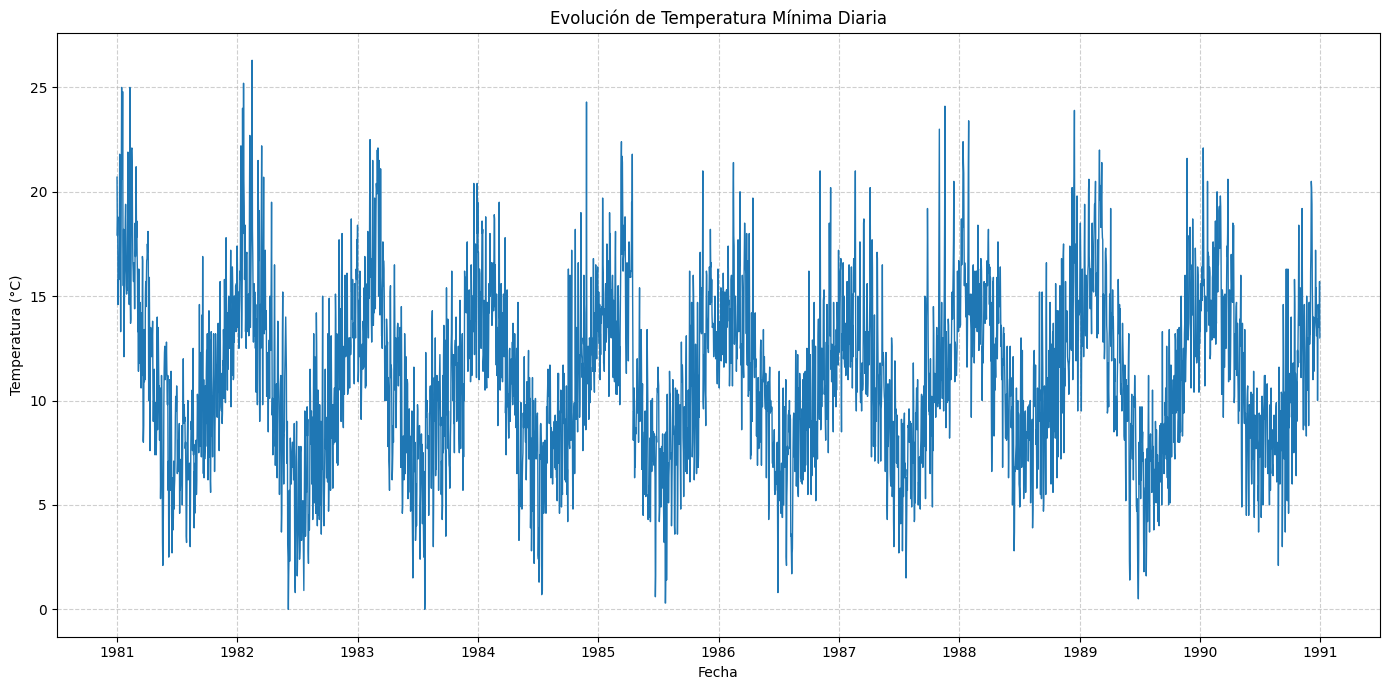


4.2 Estadísticas Descriptivas de 'Temperatura Mínima Diaria'...
Estadísticas detalladas:
  Promedio (Media): 11.1793
  Mediana: 11.0000
  Moda: 10.0000
  Desviación Estándar: 4.0681
  Varianza: 16.5497
  Mínimo: 0.0000
  Máximo: 26.3000
  Percentil 25 (Q1): 8.3000
  Percentil 75 (Q3): 14.0000
  Rango Intercuartílico (IQR): 5.7000

4.3 Análisis de Granularidad, Máximos y Mínimos para 'Temperatura Mínima Diaria'...
Granularidad (diferencias más frecuentes en días):
| fecha   | count   |
|:--------|:--------|
| 1       | 3647    |
| 2       | 2       |
Comentario: La serie tiene una granularidad predominantemente diaria.

Máximo absoluto: 26.3000 el 1982-02-15
Mínimo absoluto: 0.0000 el 1982-06-05


In [30]:
if serie_original is not None and not serie_original.empty:
    print("\n--- 4. Análisis Exploratorio (EDA) - Parte 1 ---")
    visualizar_serie_temporal(serie_original, titulo=f"Evolución de {NOMBRE_SERIE}", ylabel=UNIDAD_Y)
    stats_desc = calcular_estadisticas_descriptivas(serie_original)
    analizar_granularidad_max_min(serie_original)
else:
    print("La serie original no está disponible para EDA.")

##### EDA - Tendencia y Estacionalidad


--- 4. Análisis Exploratorio (EDA) - Parte 2 ---

4.4 Visualizando Tendencia (Media Móvil 365 días) para 'Temperatura Mínima Diaria'...


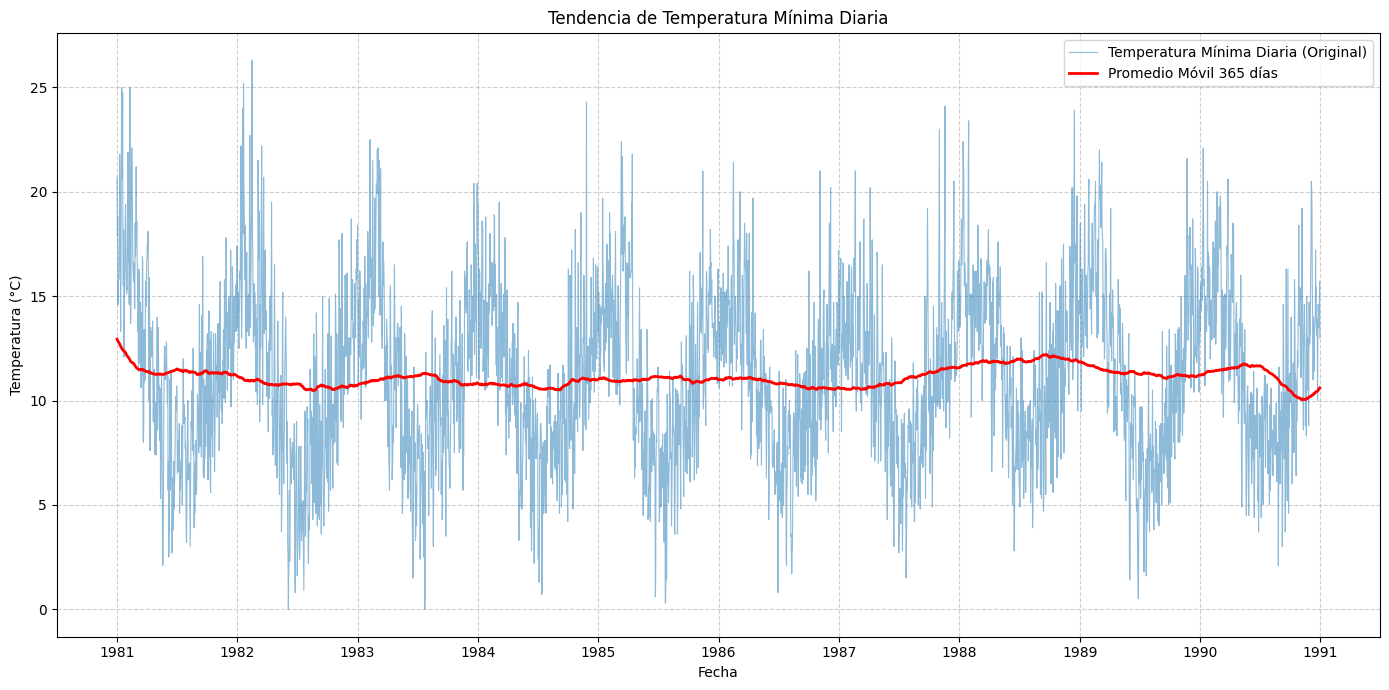


4.5 Descomponiendo 'Temperatura Mínima Diaria' (Periodo=365, Modelo=additive)...


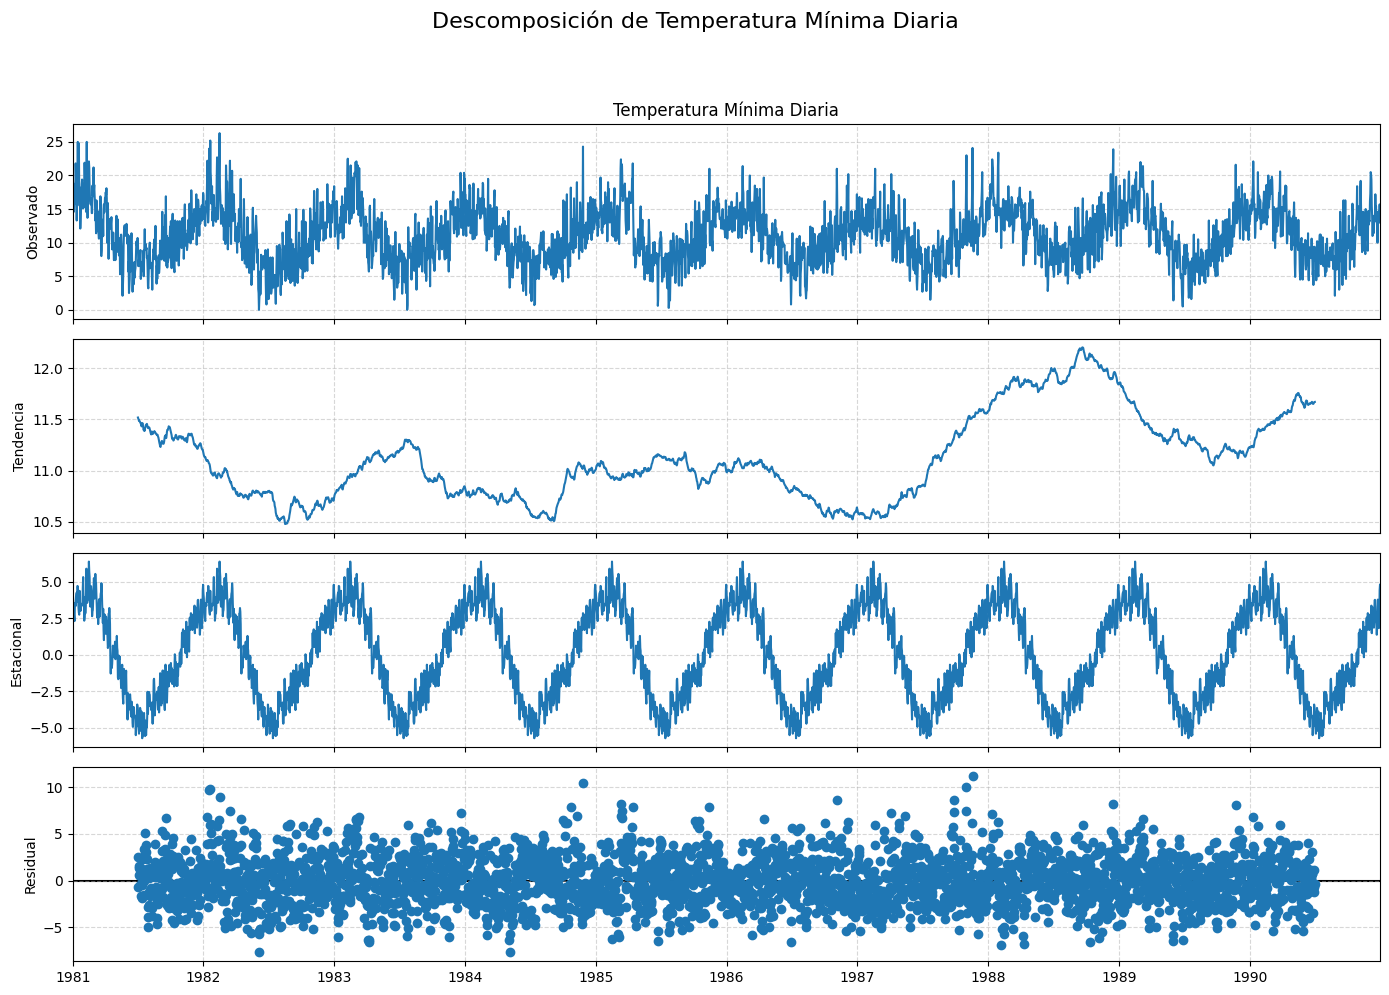

In [31]:
if serie_original is not None and not serie_original.empty:
    print("\n--- 4. Análisis Exploratorio (EDA) - Parte 2 ---")
    visualizar_tendencia_media_movil(serie_original, VENTANA_MEDIA_MOVIL, titulo=f"Tendencia de {NOMBRE_SERIE}", ylabel=UNIDAD_Y)
    descomposicion = descomponer_serie_estacional(serie_original, PERIODO_ESTACIONAL, model='additive', titulo=f"Descomposición de {NOMBRE_SERIE}")
else:
    print("La serie original no está disponible para EDA.")

##### EDA - Picos/Valles y Cambio Anual


--- 4. Análisis Exploratorio (EDA) - Parte 3 ---

4.6 Identificando Picos y Valles en 'Temperatura Mínima Diaria' (distance=180)...


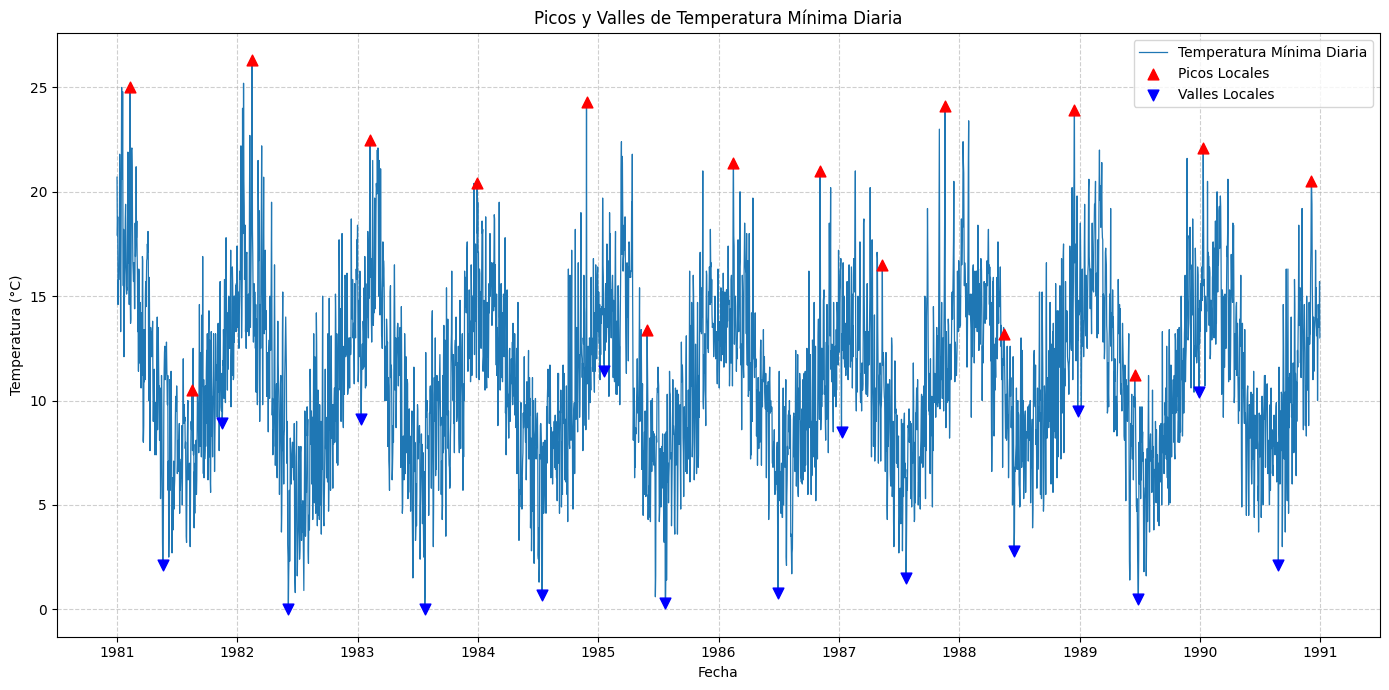

Número de picos locales detectados: 16
Número de valles locales detectados: 16

4.7 Calculando Cambio Promedio Anual para 'Temperatura Mínima Diaria'...
Primeras filas del cambio promedio anual:
|    | Año   | Cambio Promedio Anual (%)   |
|:---|:------|:----------------------------|
| 0  | 1982  | -6.24911                    |
| 1  | 1983  | 3.61067                     |
| 2  | 1984  | -5.30685                    |
| 3  | 1985  | 5.13358                     |
| 4  | 1986  | -3.00108                    |


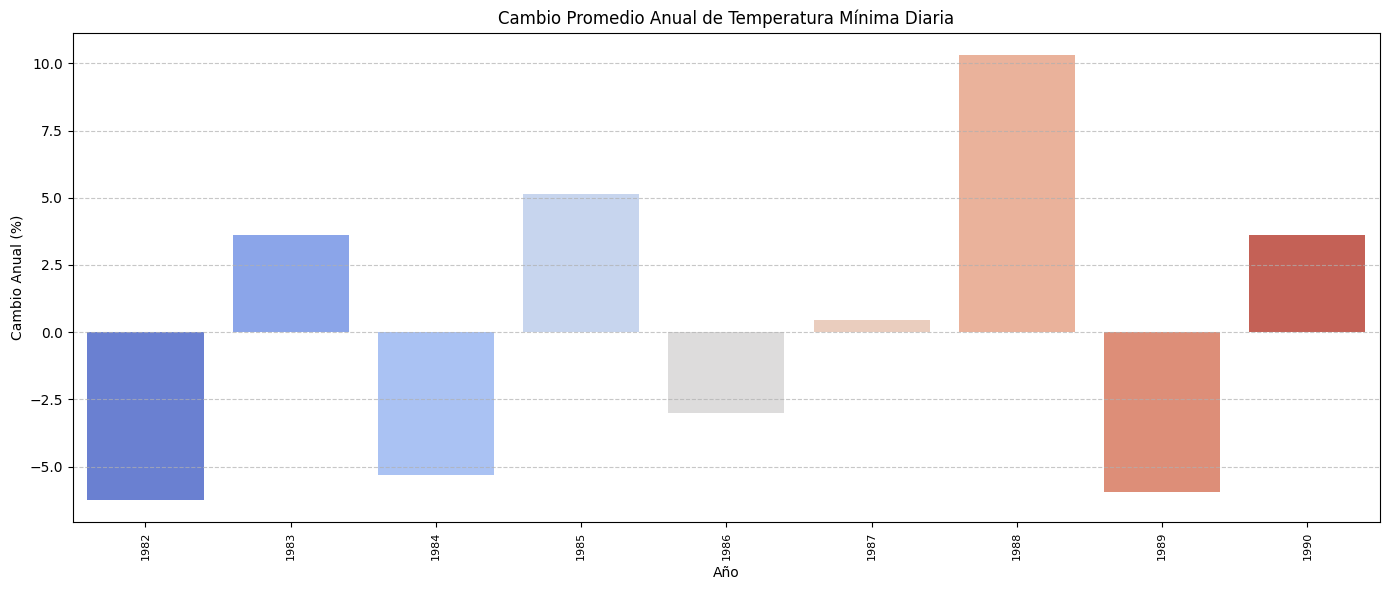

In [32]:
if serie_original is not None and not serie_original.empty:
    print("\n--- 4. Análisis Exploratorio (EDA) - Parte 3 ---")
    picos, valles = identificar_picos_valles(serie_original, DISTANCIA_PICOS_VALLES, PROMINENCIA_PICOS_VALLES, titulo=f"Picos y Valles de {NOMBRE_SERIE}", ylabel=UNIDAD_Y)
    cambio_anual = calcular_cambio_promedio_anual(serie_original, titulo=f"Cambio Promedio Anual de {NOMBRE_SERIE}", ylabel="Cambio Anual (%)")
else:
    print("La serie original no está disponible para EDA.")

#### **Metodología BOX-JENKINS para modelo ARIMA**

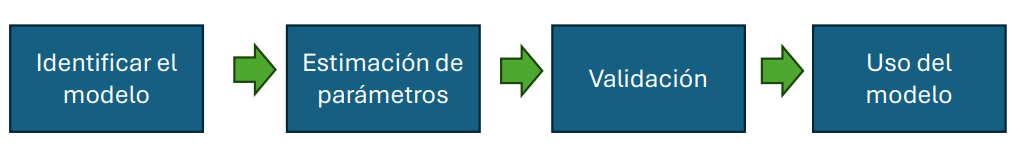

##### **Identificación**


--- 5. Metodología Box-Jenkins (ARIMA) - Identificación ---

5.1.1 Resultados de la Prueba Dickey-Fuller Aumentada para Temperatura Mínima Diaria:
|                             | 0           |
|:----------------------------|:------------|
| Test Statistic              | -4.44052    |
| p-value                     | 0.000251472 |
| #Lags Used                  | 20          |
| Number of Observations Used | 3629        |
| Critical Value (1%)         | -3.43215    |
| Critical Value (5%)         | -2.86234    |
| Critical Value (10%)        | -2.56719    |
  Conclusión: La serie es probablemente estacionaria (p-value=0.0003).

La serie original 'Temperatura Mínima Diaria' ES estacionaria (d=0).

5.1.2 Analizando ACF y PACF de 'Temperatura Mínima Diaria' (d=0)...


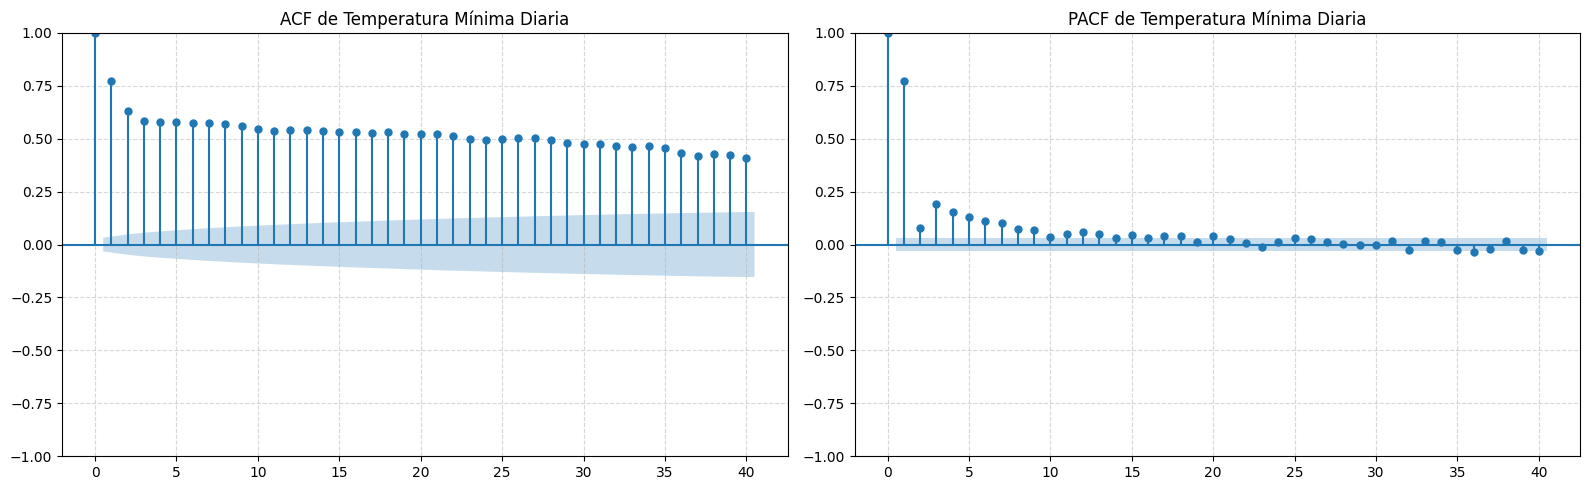


Órdenes seleccionados (p,d,q): (3, 0, 1)
Basado en parámetros iniciales p=3, q=1 y d=0 calculado.
¡Asegúrate de ajustar 'p_elegido' y 'q_elegido' si las gráficas sugieren valores diferentes!
Orden ARIMA a usar: (3, 0, 1)
Nota: La estacionalidad visible sugiere que SARIMA sería más apropiado.


In [33]:
# ARIMA - Identificación (d, p, q)

if serie_original is not None and not serie_original.empty:
    print("\n--- 5. Metodología Box-Jenkins (ARIMA) - Identificación ---")
    # 5.1 Identificación (Determinar 'd' y visualizar ACF/PACF)
    orden_d, serie_estacionaria = identificar_orden_diferenciacion(serie_original)
    visualizar_acf_pacf(serie_estacionaria, lags=LAGS_ACF_PACF, titulo_extra=f"(d={orden_d})")

    # --- ¡¡¡ IMPORTANTE: AJUSTA P y Q AQUÍ basado en las gráficas ACF/PACF !!! ---
    p_elegido = P_INICIAL # Usa el valor inicial o ajústalo
    q_elegido = Q_INICIAL # Usa el valor inicial o ajústalo
    print(f"\nÓrdenes seleccionados (p,d,q): ({p_elegido}, {orden_d}, {q_elegido})")
    print(f"Basado en parámetros iniciales p={P_INICIAL}, q={Q_INICIAL} y d={orden_d} calculado.")
    print("¡Asegúrate de ajustar 'p_elegido' y 'q_elegido' si las gráficas sugieren valores diferentes!")
    # ---------------------------------------------------------------------------

    orden_arima = (p_elegido, orden_d, q_elegido)
    print(f"Orden ARIMA a usar: {orden_arima}")
    print("Nota: La estacionalidad visible sugiere que SARIMA sería más apropiado.")
else:
    print("La serie original no está disponible para modelado.")
    # Definir variables para evitar errores en celdas posteriores si no se ejecutó
    orden_arima = None
    train_data = None
    test_data = None

##### **Estimación de Parámetros**

In [34]:
# ARIMA - Estimación (Ajuste del Modelo)

modelo_ajustado = None # Inicializar
if serie_original is not None and not serie_original.empty and orden_arima is not None:
    print("\n--- 5. Metodología Box-Jenkins (ARIMA) - Estimación ---")

    # 5.2 Estimación
    train_data, test_data = dividir_datos_entrenamiento_prueba(serie_original, train_ratio=RATIO_ENTRENAMIENTO)

    if train_data is not None and not train_data.empty:
        modelo_ajustado = ajustar_modelo_arima(train_data, order=orden_arima)
        # Intento con modelo simple si falla el inicial y no es ya el simple
        if modelo_ajustado is None and orden_arima != (1, orden_arima[1], 1):
            print("\nIntentando con modelo más simple ARIMA(1,d,1)...")
            orden_arima_simple = (1, orden_arima[1], 1) # Mantiene la 'd' calculada
            modelo_ajustado = ajustar_modelo_arima(train_data, order=orden_arima_simple)
            if modelo_ajustado:
                orden_arima = orden_arima_simple # Actualizar orden si el simple funcionó
                print(f"Modelo ajustado con éxito usando orden simple: {orden_arima}")
    else:
        print("No hay datos de entrenamiento disponibles.")
else:
    print("No se puede estimar el modelo (falta serie original u orden ARIMA).")


--- 5. Metodología Box-Jenkins (ARIMA) - Estimación ---

--- División de Datos ---
Tamaño Total: 3650, Ratio Entrenamiento: 90.0%
Tamaño Entrenamiento: 3285 (1981-01-01 a 1989-12-31)
Tamaño Prueba:      365 (1990-01-01 a 1990-12-31)

--- 5.2 Ajustando modelo ARIMA(3, 0, 1) ---

Resumen del Modelo Ajustado:
                                   SARIMAX Results                                   
Dep. Variable:     Temperatura Mínima Diaria   No. Observations:                 3285
Model:                        ARIMA(3, 0, 1)   Log Likelihood               -7563.961
Date:                       Sat, 26 Apr 2025   AIC                          15139.923
Time:                               07:27:12   BIC                          15176.506
Sample:                                    0   HQIC                         15153.021
                                      - 3285                                         
Covariance Type:                         opg                                         
   

##### **Evaluación o Validación del Modelo**


--- 5. Metodología Box-Jenkins (ARIMA) - Diagnóstico ---

--- 5.3 Diagnóstico del Modelo ---

5.3.1 Gráfico de Residuos vs Tiempo...


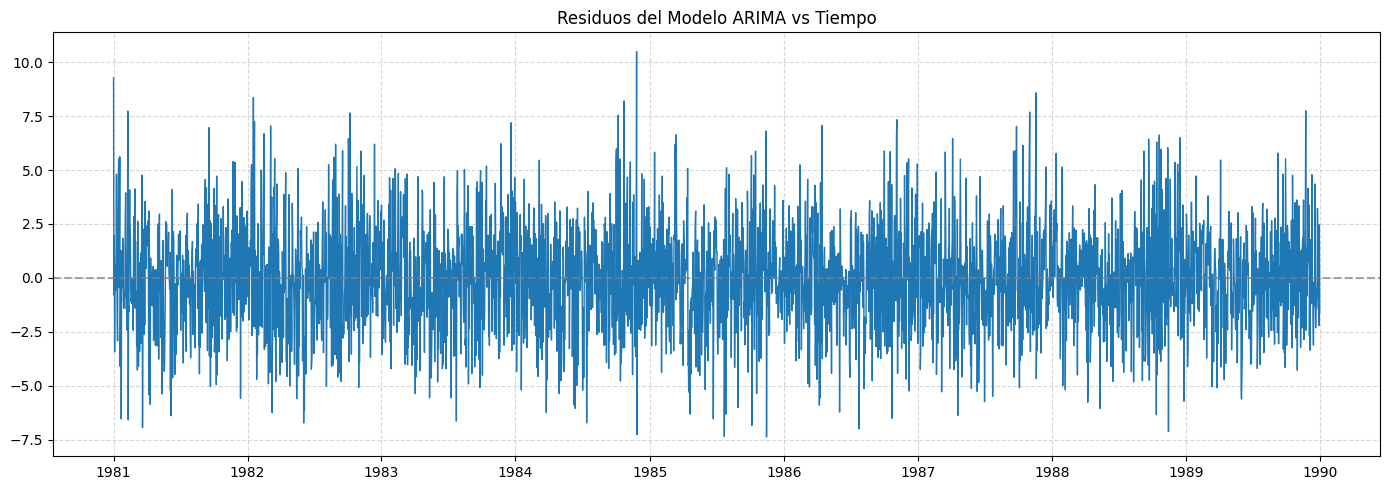


5.3.2 ACF y QQ-Plot de Residuos...


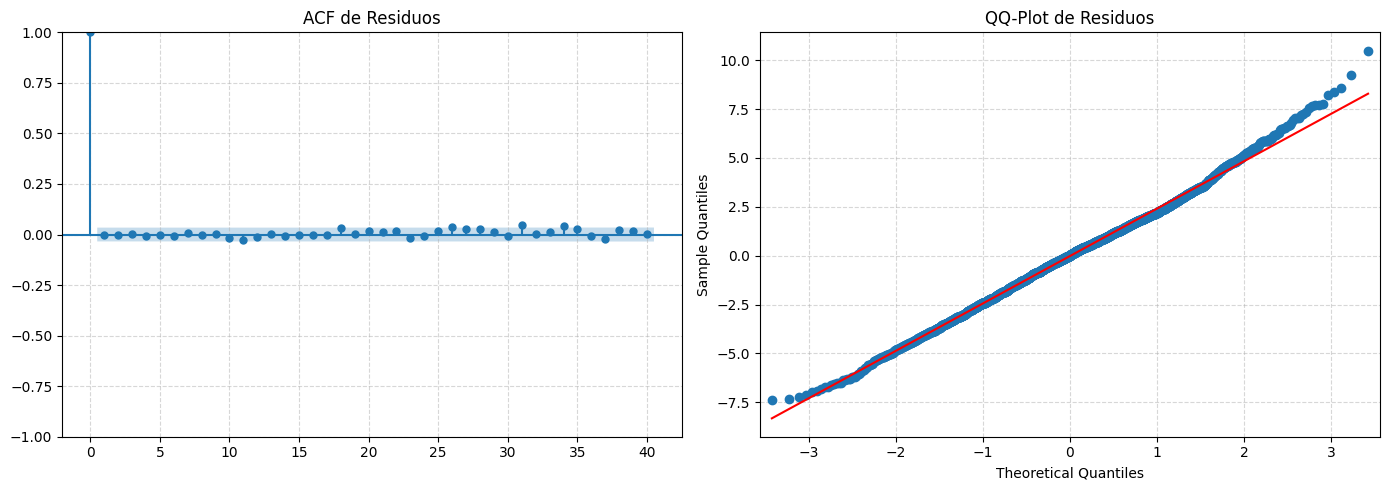


5.3.3 Prueba de Ljung-Box para autocorrelación de residuos...
|    | lb_stat    | lb_pvalue   |
|:---|:-----------|:------------|
| 1  | 0.00523084 | 0.942344    |
| 2  | 0.0194077  | 0.990343    |
| 3  | 0.0492275  | 0.997138    |
| 4  | 0.245835   | 0.993037    |
| 5  | 0.297012   | 0.997699    |
| 6  | 0.430225   | 0.998587    |
| 7  | 0.645321   | 0.998722    |
| 8  | 0.648926   | 0.999643    |
| 9  | 0.731433   | 0.999847    |
| 10 | 1.84348    | 0.997405    |
| 11 | 3.99754    | 0.969989    |
| 12 | 4.38287    | 0.975496    |
| 13 | 4.39742    | 0.986183    |
| 14 | 4.62991    | 0.990326    |
| 15 | 4.6364     | 0.994783    |
| 16 | 4.63659    | 0.997285    |
| 17 | 4.6371     | 0.998624    |
| 18 | 7.95664    | 0.979275    |
| 19 | 7.98332    | 0.986838    |
| 20 | 9.28837    | 0.97932     |
| 21 | 9.82576    | 0.981087    |
| 22 | 10.6229    | 0.979724    |
| 23 | 11.4004    | 0.978719    |
| 24 | 11.531     | 0.984694    |
| 25 | 12.524     | 0.981818    |
| 26 | 16.5617    |

In [35]:
# ARIMA - Diagnóstico del Modelo
diagnostico_ok = False # Inicializar
if modelo_ajustado is not None:
    print("\n--- 5. Metodología Box-Jenkins (ARIMA) - Diagnóstico ---")
    # 5.3 Diagnóstico
    diagnostico_ok = diagnosticar_modelo(modelo_ajustado, lags=LAGS_ACF_PACF)
    print(f"\nResultado del Diagnóstico: {'Satisfactorio' if diagnostico_ok else 'Insatisfactorio'}")
else:
    print("El modelo no está ajustado, no se puede realizar diagnóstico.")

##### **Uso o aplicación del modelo**


--- 5. Metodología Box-Jenkins (ARIMA) - Predicción y Evaluación ---

--- 5.4 Realizando Predicción (365 pasos) ---
Predicciones generadas exitosamente.

5.4.1 Visualización de Predicciones vs Datos Reales...


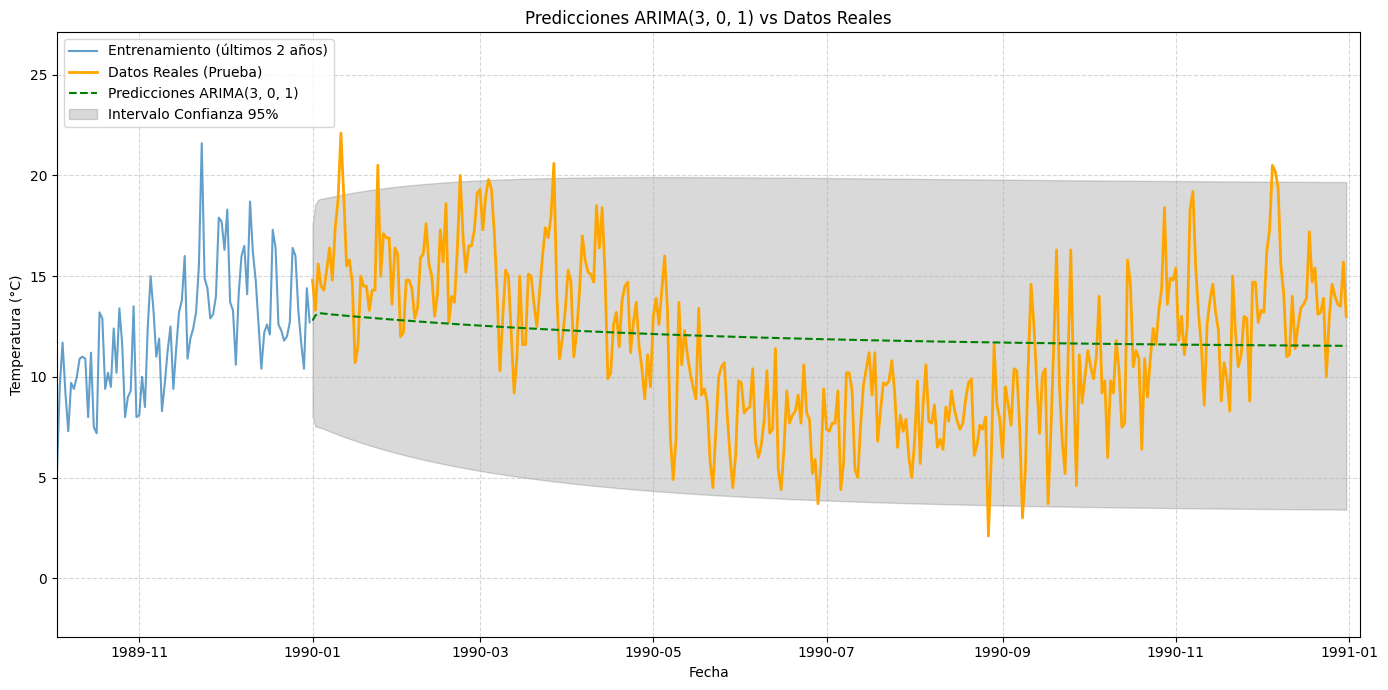


5.4.2 Evaluación Numérica del Modelo...
  Root Mean Squared Error (RMSE): 3.6937
  Mean Absolute Error (MAE):      3.0705
  Mean Absolute Percentage Error (MAPE): 34.35%


In [36]:
# ARIMA - Predicción y Evaluación

predicciones = None
intervalos_conf = None
metricas = None # Inicializar

if modelo_ajustado is not None and test_data is not None and not test_data.empty:
    print("\n--- 5. Metodología Box-Jenkins (ARIMA) - Predicción y Evaluación ---")
    # 5.4 Predicción y Evaluación
    predicciones, intervalos_conf = realizar_prediccion(modelo_ajustado, steps=len(test_data), test_index=test_data.index)

    if predicciones is not None:
         visualizar_prediccion(train_data, test_data, predicciones, intervalos_conf, order=orden_arima, ylabel=UNIDAD_Y)
         metricas = evaluar_prediccion(test_data, predicciones)
    else:
        print("No se pudieron generar predicciones.")
else:
    print("No se puede realizar predicción/evaluación (modelo no ajustado o datos de prueba faltantes).")

#### **Conclusiones Finales**

In [37]:
print(f"\n--- 6. Conclusiones Finales ---")

# Verificar si las variables necesarias existen antes de usarlas
if 'serie_original' in locals() and serie_original is not None and not serie_original.empty:
    print(f"Análisis de la serie '{NOMBRE_SERIE}' ({serie_original.index.min().strftime('%Y-%m-%d')} a {serie_original.index.max().strftime('%Y-%m-%d')}).")
else:
    print("Análisis de la serie no completado debido a errores previos.")
    # Salir o manejar de otra forma si la serie original no se cargó

if 'orden_arima' in locals() and orden_arima is not None:
     print(f"Modelo ARIMA intentado: ARIMA{orden_arima}.")
else:
     print("No se determinó un orden ARIMA.")

if 'modelo_ajustado' in locals() and modelo_ajustado is not None:
    if 'diagnostico_ok' in locals():
         print(f"Diagnóstico del modelo: {'Satisfactorio (residuos como ruido blanco)' if diagnostico_ok else 'Insatisfactorio (autocorrelación residual detectada)'}.")
         if not diagnostico_ok: print("  -> Probablemente debido a estacionalidad no modelada.")
    else:
         print("Diagnóstico del modelo no realizado.")
else:
    print("El modelo ARIMA no pudo ser ajustado.")

if 'metricas' in locals() and metricas is not None:
    print("Rendimiento en el conjunto de prueba:")
    for key, value in metricas.items():
         if value is not None:
            try:
                print(f"  - {key}: {value:.4f}")
            except TypeError:
                 print(f"  - {key}: {value}") # Imprimir si no es formateable
elif 'modelo_ajustado' in locals() and modelo_ajustado is not None:
     print("No se pudieron calcular las métricas de rendimiento (posiblemente error en predicción/evaluación).")

print("\nRecomendación General:")
print("La fuerte estacionalidad anual detectada en el EDA y (probablemente) en el diagnóstico de residuos indica que un modelo ARIMA simple es insuficiente.")
print(f"Se recomienda encarecidamente utilizar modelos estacionales como SARIMA(p,d,q)(P,D,Q)[{PERIODO_ESTACIONAL}] para capturar adecuadamente la dinámica de esta serie de tiempo.")

print("\n--- Análisis Completado ---")


--- 6. Conclusiones Finales ---
Análisis de la serie 'Temperatura Mínima Diaria' (1981-01-01 a 1990-12-31).
Modelo ARIMA intentado: ARIMA(3, 0, 1).
Diagnóstico del modelo: Satisfactorio (residuos como ruido blanco).
Rendimiento en el conjunto de prueba:
  - RMSE: 3.6937
  - MAE: 3.0705
  - MAPE: 34.3506

Recomendación General:
La fuerte estacionalidad anual detectada en el EDA y (probablemente) en el diagnóstico de residuos indica que un modelo ARIMA simple es insuficiente.
Se recomienda encarecidamente utilizar modelos estacionales como SARIMA(p,d,q)(P,D,Q)[365] para capturar adecuadamente la dinámica de esta serie de tiempo.

--- Análisis Completado ---
